In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import random
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [2]:
data = pd.read_csv('Data.csv')

In [3]:
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
seed_all(10)

[ Using Seed :  10  ]


# Визуализация, анализ, преобработка

In [5]:
data.head(10)

,date_time,cash
0,2018-01-09T10:11:05Z,205146.000279
1,2018-01-09T13:19:10Z,152027.951693
2,2018-01-09T13:22:27Z,1910.088333
3,2018-01-09T13:23:30Z,181898.214643
4,2018-01-09T13:30:11Z,82061.541704
5,2018-01-09T13:34:14Z,91.106187
6,2018-01-10T09:28:15Z,37104.094194
7,2018-01-10T09:31:09Z,123.778751
8,2018-01-10T12:53:59Z,193000.603081
9,2018-01-10T12:57:58Z,207.345115


### Представим значения в графическом виде

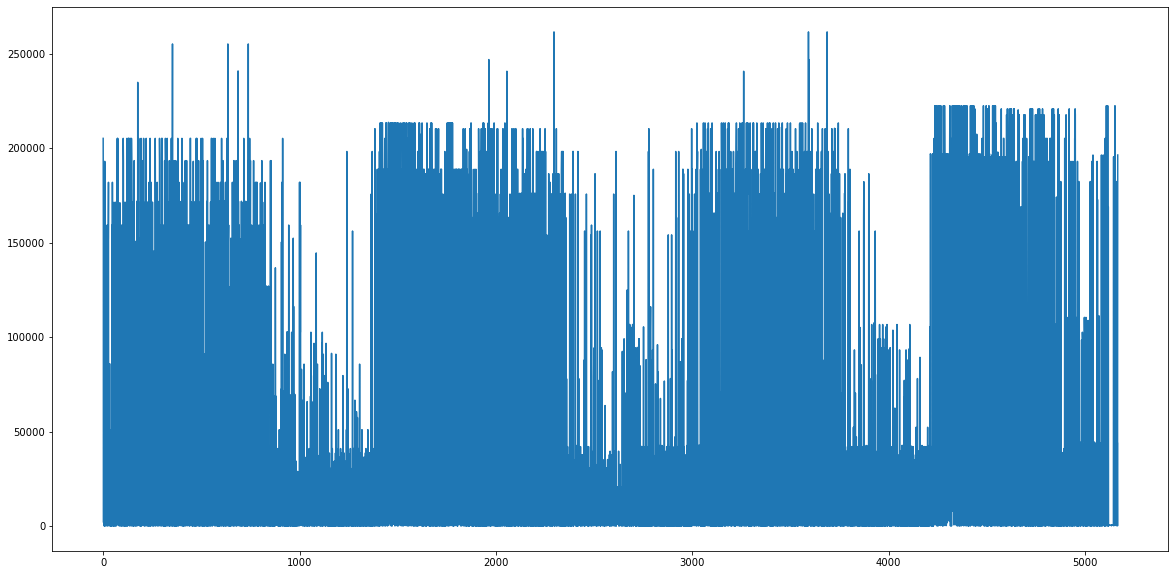

In [6]:
plt.figure(figsize=[20,10])
plt.plot(data.cash)
plt.show()

Видны участки больших постоянных значений и "провалы". Более подробно можно рассмотреть график из столбцов, поскольку соединение соседних точек зашумляет изображение

### Построим bar-график

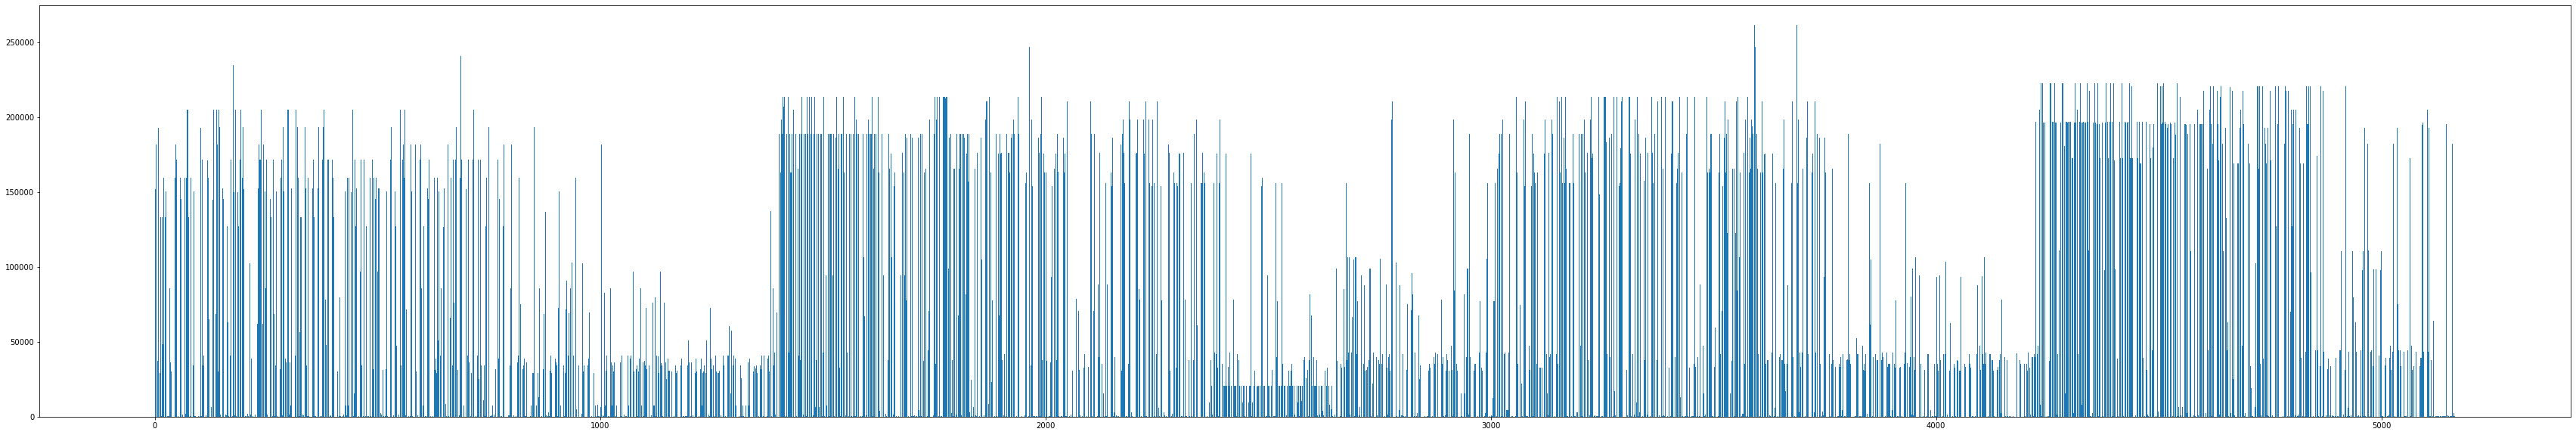

In [7]:
plt.figure(figsize=[60,10])
plt.bar(data.index,data.cash)
plt.show()

Все еще заметна определенная периодичность данных, причем интервалы между областями больших и малых значений достаточно велики. Имеет смысл предположить, что значения, соответствующие разному времени в пределах одних суток можно объединить, поскольку нас мало интересует высокочастотная периодическая составляющая

### Преобразуем данные: объединяем значения в пределах одних суток

In [8]:
data.date_time=data.date_time.str[:10]

In [9]:
data

,date_time,cash
0,2018-01-09,205146.000279
1,2018-01-09,152027.951693
2,2018-01-09,1910.088333
3,2018-01-09,181898.214643
4,2018-01-09,82061.541704
...,...,...
5163,2019-12-27,2513.274123
5164,2019-12-27,471.238898
5165,2019-12-28,44156.341383
5166,2019-12-28,140.115032


In [10]:
data = data.groupby(['date_time'], as_index=False).sum()

In [11]:
data

,date_time,cash
0,2018-01-09,6.231349e+05
1,2018-01-10,4.189314e+05
2,2018-01-11,1.376951e+06
3,2018-01-12,1.013318e+06
4,2018-01-13,3.388264e+05
...,...,...
517,2019-12-24,6.657035e+05
518,2019-12-25,6.382145e+05
519,2019-12-26,4.517610e+05
520,2019-12-27,6.332728e+05


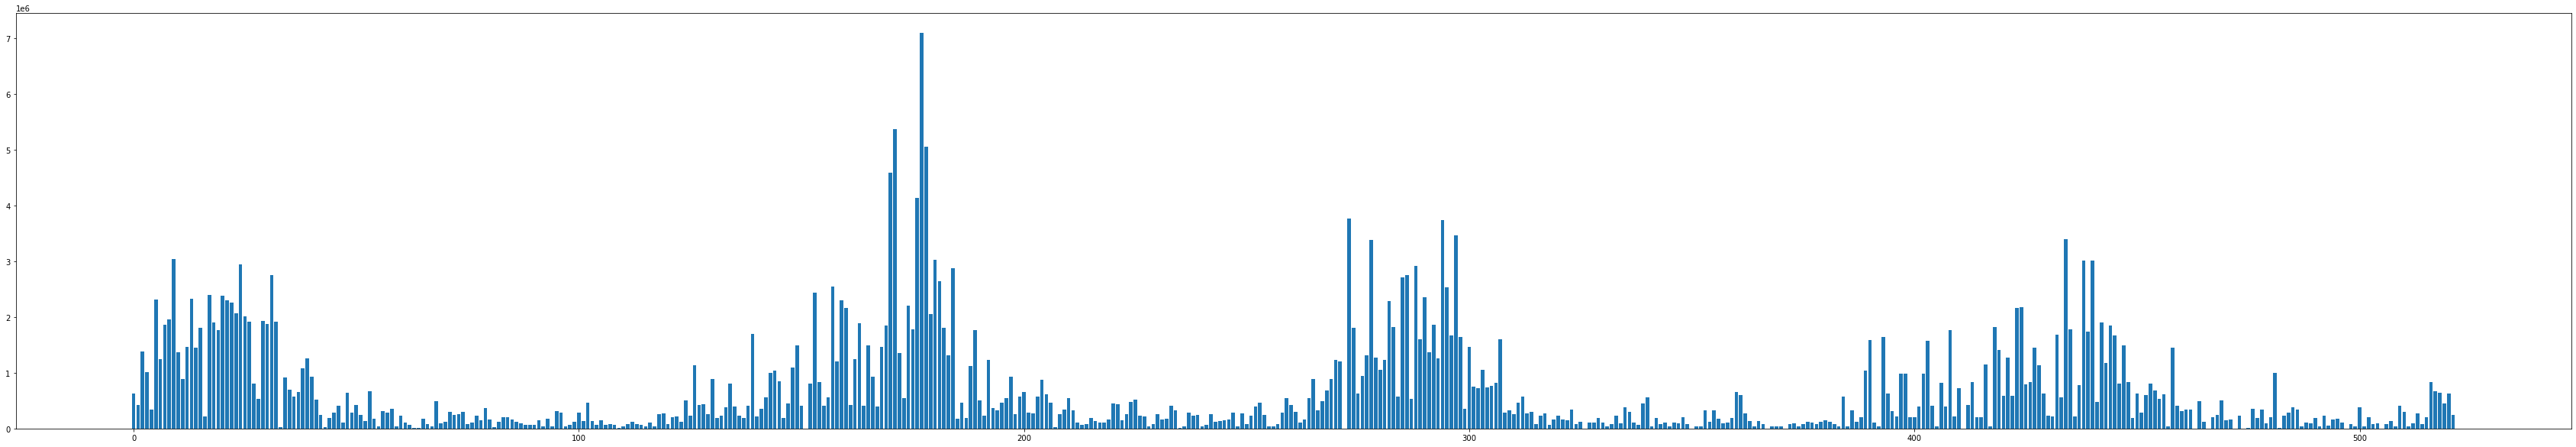

In [12]:
plt.figure(figsize=[60,10])
plt.bar(data.index,data.cash)
plt.show()

Имеющиеся участки больших значений достаточно хорошо отделены интервалами с малыми значениями, что говорит об определенной сезонности данных. Пик во втором участке выглядит необычно, возможно это связано с какими-то экстраординарными событиями и требует корректировки. В остальном, формы пиков похожи на зашумленные гауссовы распределения с некоторым количеством выбросов. 

### Разобьем данные по годам

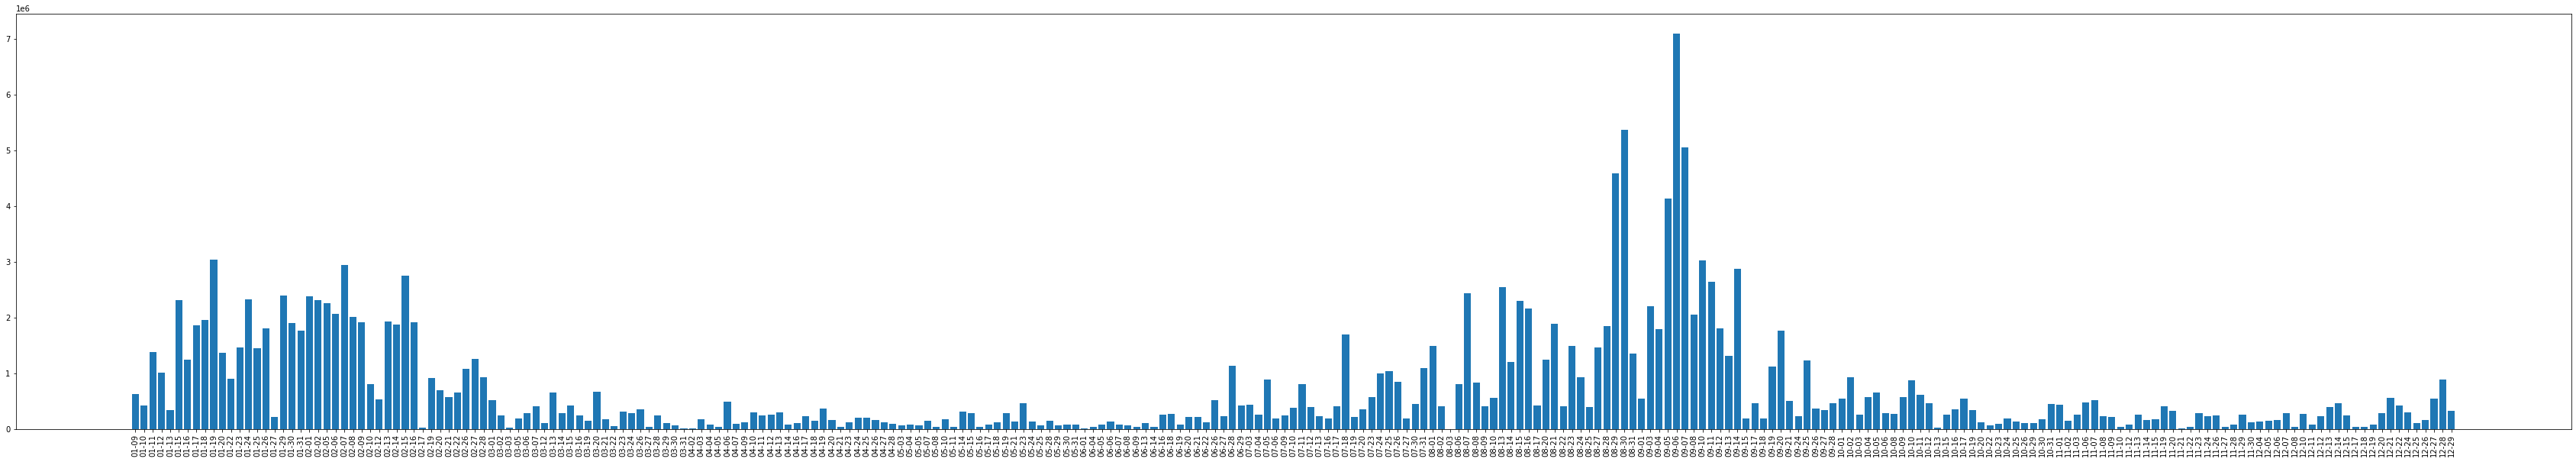

In [13]:
plt.figure(figsize=[60,10])
plt.bar(data.date_time.str[5:][:267],data.cash[:267])
plt.xticks(data.date_time.str[5:][:267], rotation='vertical')
plt.show()

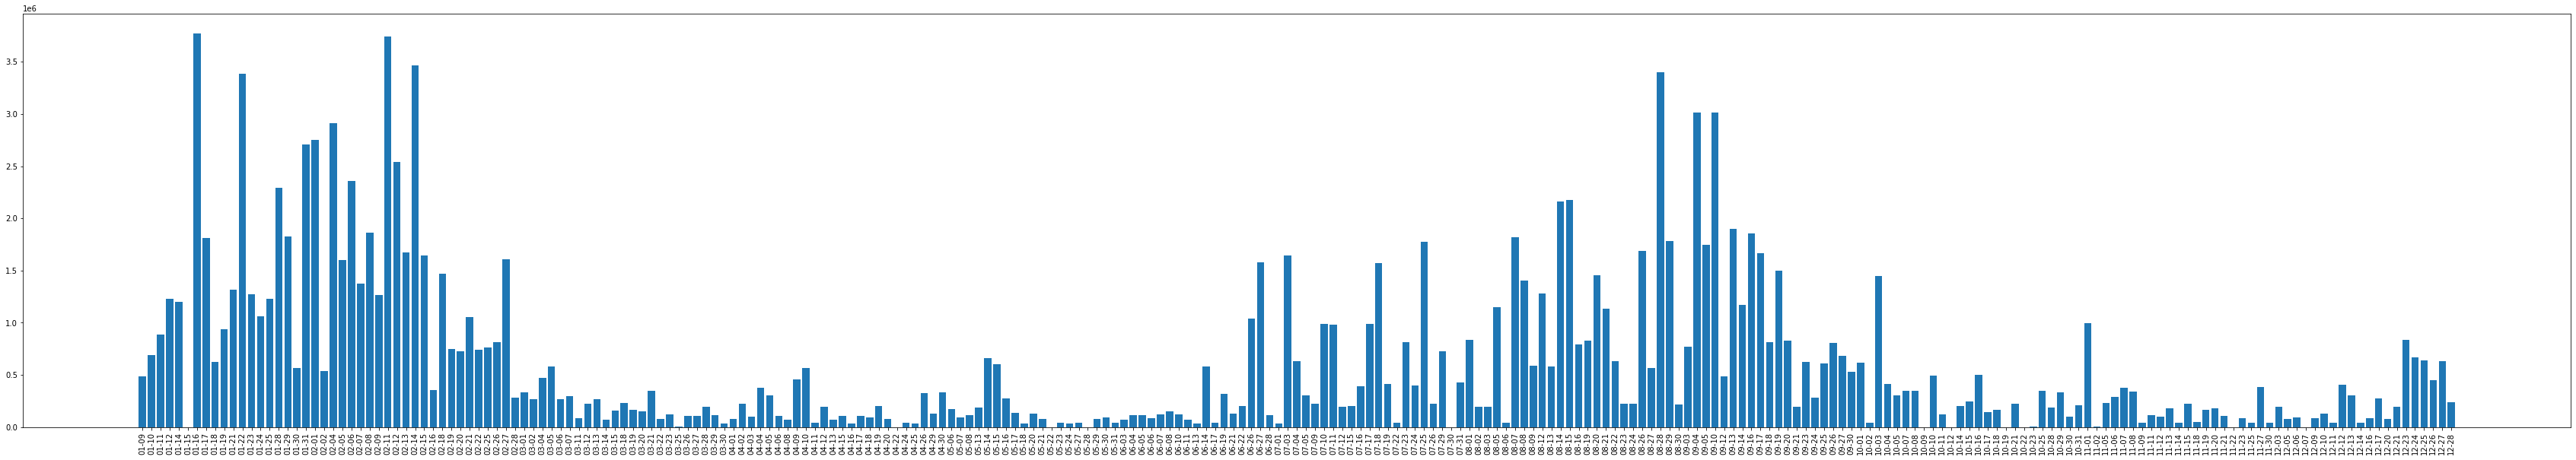

In [14]:
plt.figure(figsize=[60,10])
plt.bar(data.date_time.str[5:][267:],data.cash[267:])
plt.xticks(data.date_time.str[5:][267:], rotation='vertical')
plt.show()

Видно, что участки больших значений соответствуют примерно одинаковым временным интервалам

### Стационарность временных рядов

##### Kwiatkowski–Phillips–Schmidt–Shin

In [15]:
kpss_stat, p_value, *args = kpss(data.cash, regression='c', nlags="auto", store=False)

R:\conda\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [16]:
print(f"KPSS: {kpss_stat}, P: {p_value}")

KPSS: 0.17405542815170838, P: 0.1


Для KPSS P > 0.05 ===> ряд стационарен

##### Augmented Dickey–Fuller

In [17]:
adf_stat, pvalue, *args = adfuller(data.cash)

In [18]:
print(f"ADF: {adf_stat}, P: {pvalue}")

ADF: -3.3582135325796107, P: 0.012468575009332038


Для ADF P < 0.05 ===> ряд стационарен

### Автокорреляция

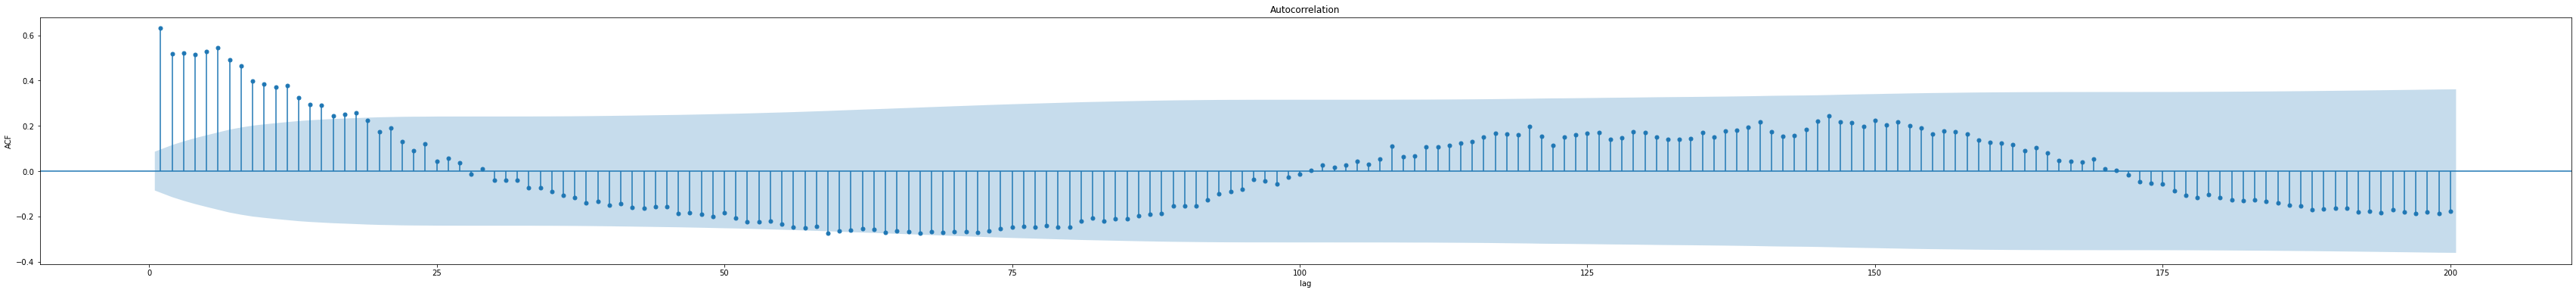

In [19]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(60, 6))
    plot_acf(data.cash, lags=200, zero=False)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.show()

Не самая удачная АКФ. С одной стороны сезонность видна, с другой стороны, отсчеты малы по амплитуде (не выходят из синей зоны). Наличие сезонности тем более смущает, учитывая стационарность ряда по двум гипотезам. Вероятно, это связано с малой амплитудой.

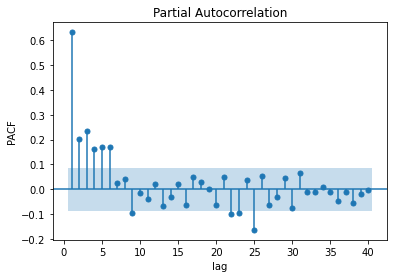

In [20]:
plot_pacf(data.cash, lags=40, zero=False)
plt.ylabel('PACF')
plt.xlabel('lag')
plt.show()

Данный график мало о чем говорит

In [21]:
#box, maxlog = boxcox(data.cash)

In [22]:
#plt.figure(figsize=[16,1.5])
#plt.plot(box)
#plt.show()

In [23]:
#data.cash.max()

In [24]:
#data.loc[data.cash==data.cash.max()]

# Моделирование

### Ridge

Базовая гипотеза — использовать необработанные данные без дополнительных признаков. Разбиваем дату на год, день и месяц и сопоставляем значение из столбца cash.

In [25]:
data['year']=data.date_time.str[:4]
data['month']=data.date_time.str[5:7]
data['day']=data.date_time.str[8:10]
data

,date_time,cash,year,month,day
0,2018-01-09,6.231349e+05,2018,01,09
1,2018-01-10,4.189314e+05,2018,01,10
2,2018-01-11,1.376951e+06,2018,01,11
3,2018-01-12,1.013318e+06,2018,01,12
4,2018-01-13,3.388264e+05,2018,01,13
...,...,...,...,...,...
517,2019-12-24,6.657035e+05,2019,12,24
518,2019-12-25,6.382145e+05,2019,12,25
519,2019-12-26,4.517610e+05,2019,12,26
520,2019-12-27,6.332728e+05,2019,12,27


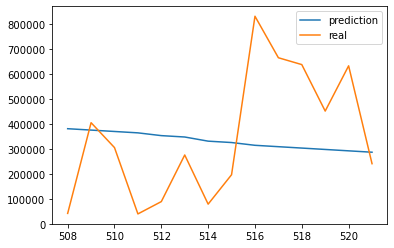

In [26]:
data_train = data[:-14]
data_test = data[-14:]

from sklearn.linear_model import Ridge
model = Ridge(alpha=0).fit(data_train.loc[:, 'year':], data_train.cash)

xaxis = data_test.index
plt.plot(xaxis, model.predict(data_test.loc[:, 'year':]), label='prediction')
plt.plot(xaxis, data_test.cash, label='real')
plt.legend()

Ожидаемо, такая модель дает результат, похожий на усреднение (ошибка может быть мала, но значения не соответствуют, что-то вроде локального минимума)

### Линейная регрессия

In [27]:
data = pd.read_csv('Data.csv')
data.date_time=data.date_time.str[:10]
data = data.groupby(['date_time'], as_index=False).sum()
data

,date_time,cash
0,2018-01-09,6.231349e+05
1,2018-01-10,4.189314e+05
2,2018-01-11,1.376951e+06
3,2018-01-12,1.013318e+06
4,2018-01-13,3.388264e+05
...,...,...
517,2019-12-24,6.657035e+05
518,2019-12-25,6.382145e+05
519,2019-12-26,4.517610e+05
520,2019-12-27,6.332728e+05


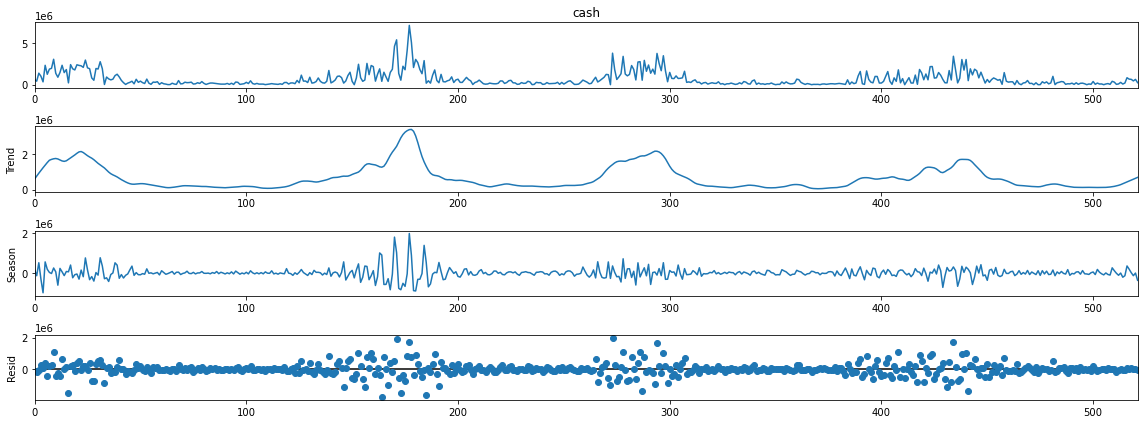

In [28]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16, 6))
    x=STL(data.cash, period=7).fit()
    x.plot()

In [29]:
data

,date_time,cash
0,2018-01-09,6.231349e+05
1,2018-01-10,4.189314e+05
2,2018-01-11,1.376951e+06
3,2018-01-12,1.013318e+06
4,2018-01-13,3.388264e+05
...,...,...
517,2019-12-24,6.657035e+05
518,2019-12-25,6.382145e+05
519,2019-12-26,4.517610e+05
520,2019-12-27,6.332728e+05


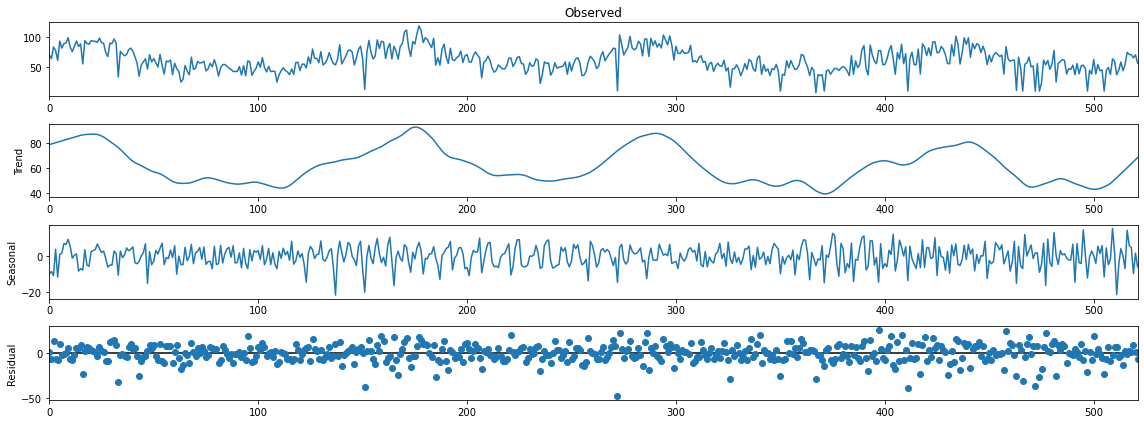

In [30]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16, 6))
    x=STL(boxcox(data.cash)[0], period=14).fit()
    x.plot()

In [31]:
_, lmbda = boxcox(data.cash)

In [32]:
x.resid.mean()

-0.02855909384750218

Преобразуем данные так, чтобы каждый следующий столбец был сдвигом оригинального "сигнала" на один лаг по времени. Это даст возможность передавать в регрессию взаимосвязь предыдущих значений с последующим.

In [33]:
#data.cash = boxcox(data.cash)[0]

data

,date_time,cash
0,2018-01-09,6.231349e+05
1,2018-01-10,4.189314e+05
2,2018-01-11,1.376951e+06
3,2018-01-12,1.013318e+06
4,2018-01-13,3.388264e+05
...,...,...
517,2019-12-24,6.657035e+05
518,2019-12-25,6.382145e+05
519,2019-12-26,4.517610e+05
520,2019-12-27,6.332728e+05


In [34]:
def data_preprocess(df, n, exogen=False):
    df['cash+1']=df['cash'].shift(-1)
    for i in range(2, n + 1):
        df[f'cash+{i}']=df[f'cash+{i-1}'].shift(-1)

    try:
        df = df.drop('date_time', axis=1)
    except:
        pass
    if exogen:
        x=STL(data.cash, period=7).fit()
        df['trend'] = x.trend
        df['season'] = x.seasonal
        df['resid'] = x.resid
    df.dropna(inplace=True)
    df = df.reset_index().drop('index', axis=1)
    #for i in range(len(df.columns)):
    #    df.loc[:, df.columns[i]] = boxcox(df.loc[:, df.columns[i]])[0]
    return df

In [35]:
n_lags=14
data = data_preprocess(data, n_lags)
data = data.copy()
data

,cash,cash+1,cash+2,cash+3,cash+4,cash+5,cash+6,cash+7,cash+8,cash+9,cash+10,cash+11,cash+12,cash+13,cash+14
0,6.231349e+05,4.189314e+05,1.376951e+06,1.013318e+06,3.388264e+05,2.319380e+06,1.244520e+06,1.864501e+06,1.956710e+06,3.042014e+06,1.367479e+06,8.947256e+05,1.459870e+06,2.322422e+06,1.446389e+06
1,4.189314e+05,1.376951e+06,1.013318e+06,3.388264e+05,2.319380e+06,1.244520e+06,1.864501e+06,1.956710e+06,3.042014e+06,1.367479e+06,8.947256e+05,1.459870e+06,2.322422e+06,1.446389e+06,1.811599e+06
2,1.376951e+06,1.013318e+06,3.388264e+05,2.319380e+06,1.244520e+06,1.864501e+06,1.956710e+06,3.042014e+06,1.367479e+06,8.947256e+05,1.459870e+06,2.322422e+06,1.446389e+06,1.811599e+06,2.167699e+05
3,1.013318e+06,3.388264e+05,2.319380e+06,1.244520e+06,1.864501e+06,1.956710e+06,3.042014e+06,1.367479e+06,8.947256e+05,1.459870e+06,2.322422e+06,1.446389e+06,1.811599e+06,2.167699e+05,2.401591e+06
4,3.388264e+05,2.319380e+06,1.244520e+06,1.864501e+06,1.956710e+06,3.042014e+06,1.367479e+06,8.947256e+05,1.459870e+06,2.322422e+06,1.446389e+06,1.811599e+06,2.167699e+05,2.401591e+06,1.903020e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,7.885398e+04,8.890707e+04,2.796017e+02,8.325221e+04,1.321354e+05,4.115486e+04,4.051084e+05,3.052057e+05,3.911283e+04,8.855836e+04,2.755177e+05,7.835383e+04,1.963495e+05,8.322079e+05,6.657035e+05
504,8.890707e+04,2.796017e+02,8.325221e+04,1.321354e+05,4.115486e+04,4.051084e+05,3.052057e+05,3.911283e+04,8.855836e+04,2.755177e+05,7.835383e+04,1.963495e+05,8.322079e+05,6.657035e+05,6.382145e+05
505,2.796017e+02,8.325221e+04,1.321354e+05,4.115486e+04,4.051084e+05,3.052057e+05,3.911283e+04,8.855836e+04,2.755177e+05,7.835383e+04,1.963495e+05,8.322079e+05,6.657035e+05,6.382145e+05,4.517610e+05
506,8.325221e+04,1.321354e+05,4.115486e+04,4.051084e+05,3.052057e+05,3.911283e+04,8.855836e+04,2.755177e+05,7.835383e+04,1.963495e+05,8.322079e+05,6.657035e+05,6.382145e+05,4.517610e+05,6.332728e+05


In [36]:
def normalize(ts):
    y_max = np.max(ts)
    y_min = np.min(ts)
    norm_ts = (ts - y_min)/(y_max - y_min)
    return norm_ts       

In [37]:
#data = data.apply(normalize)

In [38]:
test = 14
x_train = data[:-test]
x_test = data[-test:].reset_index().drop('index', axis=1)

In [39]:
lr = LinearRegression()
lrx = x_train.loc[:, :f'cash+{n_lags-1}']
lry = x_train.loc[:, f'cash+{n_lags}']
lrxtest = x_test.loc[:, :f'cash+{n_lags-1}']
lrytest = x_test.loc[:, f'cash+{n_lags}']
lr.fit(lrx, lry)
lr.score(lrx, lry)

0.5065193344633383

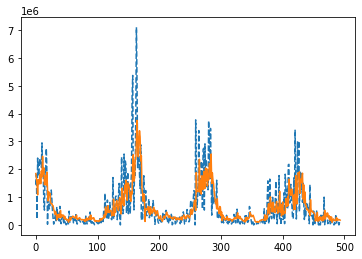

In [40]:
plt.plot(lry, '--')
plt.plot(lr.predict(lrx))
plt.show()

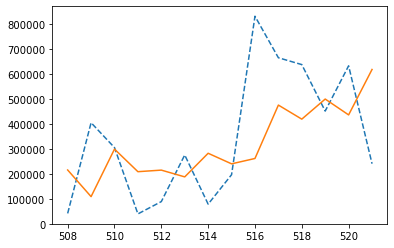

In [41]:
y_h=lr.predict(lrxtest)
xx = [len(data['cash+14']) + i for i in range(len(y_h))]
#plt.plot(data['cash+14'])
plt.plot(xx, lrytest, '--')
plt.plot(xx, lr.predict(lrxtest))


In [42]:
RSS = 0
TSS = 0
for i in range(len(lrytest)):
    RSS += (lrytest[i] - lr.predict(lrxtest)[i]) ** 2
    TSS += (lrytest[i] - lrytest.mean()) ** 2
1 - RSS/TSS

0.0883571118992359

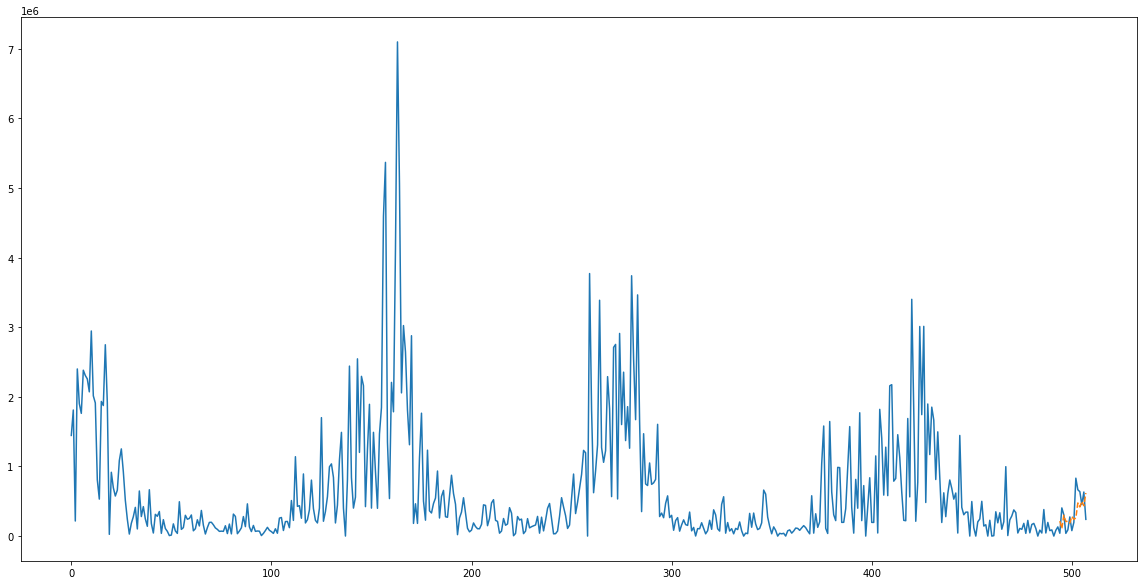

In [43]:
from scipy.special import inv_boxcox
plt.figure(figsize=[20,10])
xx = [len(data)-len(lrxtest) + i for i in range(len(lrxtest))]
plt.plot(data['cash+14'])
plt.plot(xx, lr.predict(lrxtest), '--')

### Полносвязная сеть для многошагового прогнозирования

In [44]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dp = nn.Dropout(p=0.) # лучше оставить нулевым
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.dp(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [45]:
data_ma = pd.read_csv('Data.csv')

In [46]:
data_ma.date_time=data_ma.date_time.str[:10]
data_ma = data_ma.groupby(['date_time'], as_index=False).sum()
#data_ma.cash, _ = boxcox(data_ma.cash)

Для сглаживания ряда используем скользящее среднее. Это также помогает сгладить выбросы. В идеале, их желательно заменить на адекватные значения, но учитывая малое количество выбросов и сглаживание, можно обойтись только фильтрацией скользящим средним.

In [47]:
data_ma['cashMA5'] = data_ma.loc[:,'cash'].rolling(window=9).mean()

In [48]:
data_ma.dropna(inplace=True)
data_ma

,date_time,cash,cashMA5
8,2018-01-18,1.956710e+06,1.239586e+06
9,2018-01-19,3.042014e+06,1.508350e+06
10,2018-01-20,1.367479e+06,1.613744e+06
11,2018-01-22,8.947256e+05,1.560164e+06
12,2018-01-23,1.459870e+06,1.609780e+06
...,...,...,...
517,2019-12-24,6.657035e+05,3.206797e+05
518,2019-12-25,6.382145e+05,3.465804e+05
519,2019-12-26,4.517610e+05,3.628644e+05
520,2019-12-27,6.332728e+05,4.288821e+05


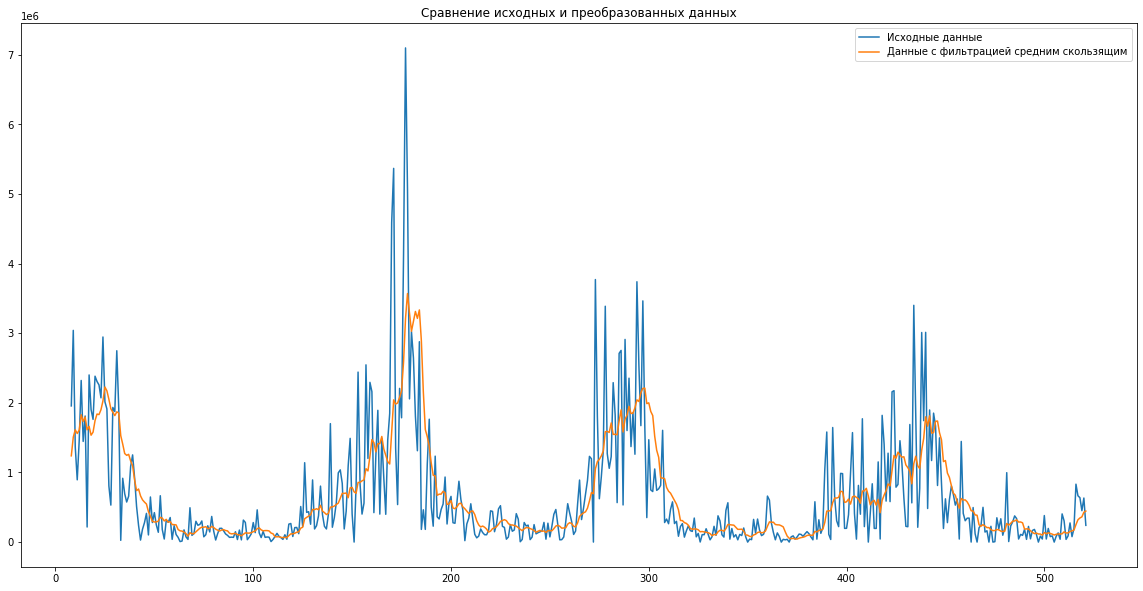

In [49]:
plt.figure(figsize=[20,10])
plt.plot(data_ma.cash, label='Исходные данные')
plt.plot(data_ma.cashMA5, label='Данные с фильтрацией средним скользящим')
plt.title('Сравнение исходных и преобразованных данных')
plt.legend()

In [50]:
def data_ma_preprocess(df, n, exogen=True):
    df['cashMA5+1']=df['cashMA5'].shift(-1)
    for i in range(2, n + 1):
        df[f'cashMA5+{i}']=df[f'cashMA5+{i-1}'].shift(-1)

    try:
        df = df.drop('date_time', axis=1)
        df = df.drop('cash', axis=1)
    except:
        pass
    if exogen:
        x=STL(data.cash, period=267).fit()
        df['trend'] = x.trend
        df['season'] = x.seasonal
        df['resid'] = x.resid
    df.dropna(inplace=True)
    df = df.reset_index().drop('index', axis=1)
    return df

In [51]:
nlags=14
data_ma = data_ma_preprocess(data_ma, nlags, exogen=False)
data_ma = data_ma.copy()
data_ma

,cashMA5,cashMA5+1,cashMA5+2,cashMA5+3,cashMA5+4,cashMA5+5,cashMA5+6,cashMA5+7,cashMA5+8,cashMA5+9,cashMA5+10,cashMA5+11,cashMA5+12,cashMA5+13,cashMA5+14
0,1.239586e+06,1.508350e+06,1.613744e+06,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,1.745390e+06,1.839553e+06,1.832423e+06
1,1.508350e+06,1.613744e+06,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,1.745390e+06,1.839553e+06,1.832423e+06,1.902006e+06
2,1.613744e+06,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,1.745390e+06,1.839553e+06,1.832423e+06,1.902006e+06,2.028152e+06
3,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,1.745390e+06,1.839553e+06,1.832423e+06,1.902006e+06,2.028152e+06,2.227992e+06
4,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,1.745390e+06,1.839553e+06,1.832423e+06,1.902006e+06,2.028152e+06,2.227992e+06,2.173756e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.249228e+05,1.145381e+05,1.023035e+05,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,1.522583e+05,1.609332e+05,1.734996e+05,2.512855e+05,3.206797e+05
496,1.145381e+05,1.023035e+05,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,1.522583e+05,1.609332e+05,1.734996e+05,2.512855e+05,3.206797e+05,3.465804e+05
497,1.023035e+05,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,1.522583e+05,1.609332e+05,1.734996e+05,2.512855e+05,3.206797e+05,3.465804e+05,3.628644e+05
498,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,1.522583e+05,1.609332e+05,1.734996e+05,2.512855e+05,3.206797e+05,3.465804e+05,3.628644e+05,4.288821e+05


Вообще говоря, данные желательно нормализовывать, но проверка модели без нормализации не приводит к взрыву градиента и ведет себя так же, как и модель на ненормализованных данных, поэтому, чтобы избегать лишних манипуляций и потери точности при нормализации и обратной операции на полученных предсказаниях, в данном случае лучше данные не нормализовывать.

In [52]:
#data_ma = data_ma.apply(normalize)
#data_ma

In [53]:
n_lags=nlags
class Train_Dataset_MA(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()   
        sample = self.df.drop([f'cashMA5+{n_lags}'], axis=1).loc[idx, 'cashMA5':]
        sample = np.array(sample)
        y = self.df.loc[idx, f'cashMA5+{n_lags}']
        y = np.array([y])
        return sample, y

In [54]:
test = 14*7
x_train_ma = data_ma[:-test]
x_test_ma = data_ma[-test:].reset_index().drop('index', axis=1)

In [55]:
x_dataset_ma = Train_Dataset_MA(x_train_ma)
x_loader_ma = DataLoader(x_dataset_ma, batch_size=49)
xt_dataset_ma = Train_Dataset_MA(x_test_ma)
xt_dataloader_ma = DataLoader(xt_dataset_ma)

In [56]:
model_ma = Net(nlags, nlags*5, 1)
print(model_ma)
num_epochs = 350
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.005

criterion = nn.MSELoss()
optimizer_ma = torch.optim.Adam(model_ma.parameters(), lr=learning_rate)
loss_lst = []
total_step = len(x_loader_ma)
for epoch in range(num_epochs):
    for batch_idx, (X, y) in enumerate(x_loader_ma):  

        X = X#.to(device)
        y = y.float()#.to(device)
      
        outputs = model_ma(X.float())

        loss = criterion(outputs, y)
        loss_lst.append(loss.detach())
          
        optimizer_ma.zero_grad()
        loss.backward()
        optimizer_ma.step()
        
    
        
      
        if (batch_idx + 1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  .format(epoch+1, num_epochs, batch_idx+1, total_step, loss.item())) 


Net(
  (fc1): Linear(in_features=14, out_features=70, bias=True)
  (dp): Dropout(p=0.0, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=70, out_features=1, bias=True)
)
Epoch [1/350], Step [1/9], Loss: 980456833024.0000
Epoch [1/350], Step [2/9], Loss: 10325519360.0000
Epoch [1/350], Step [3/9], Loss: 221835804672.0000
Epoch [1/350], Step [4/9], Loss: 708196433920.0000
Epoch [1/350], Step [5/9], Loss: 5217201152.0000
Epoch [1/350], Step [6/9], Loss: 228675960832.0000
Epoch [1/350], Step [7/9], Loss: 37103988736.0000
Epoch [1/350], Step [8/9], Loss: 21430036480.0000
Epoch [1/350], Step [9/9], Loss: 48611000320.0000
Epoch [2/350], Step [1/9], Loss: 483519594496.0000
Epoch [2/350], Step [2/9], Loss: 5144024064.0000
Epoch [2/350], Step [3/9], Loss: 20624818176.0000
Epoch [2/350], Step [4/9], Loss: 828140748800.0000
Epoch [2/350], Step [5/9], Loss: 5367316992.0000
Epoch [2/350], Step [6/9], Loss: 167038877696.0000
Epoch [2/350], Step [7/9], Loss: 11613489152.0000
Epoch [2/350], 

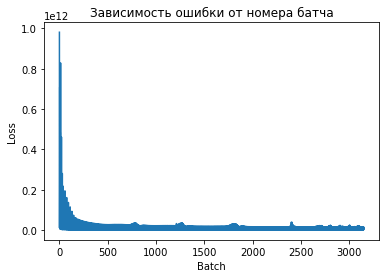

In [58]:
plt.plot(loss_lst)
plt.title('Зависимость ошибки от номера батча')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

In [59]:
loss_test = []
output_lst=[]
for batch_idx, (X, y) in enumerate(xt_dataloader_ma):  

        X = X#.to(device)
        y = y.float()#.to(device)
      
        outputs = model_ma(X.float())
        output_lst.append(outputs.detach().numpy()[0][0])

        loss = criterion(outputs, y)
        loss_test.append(loss.detach())

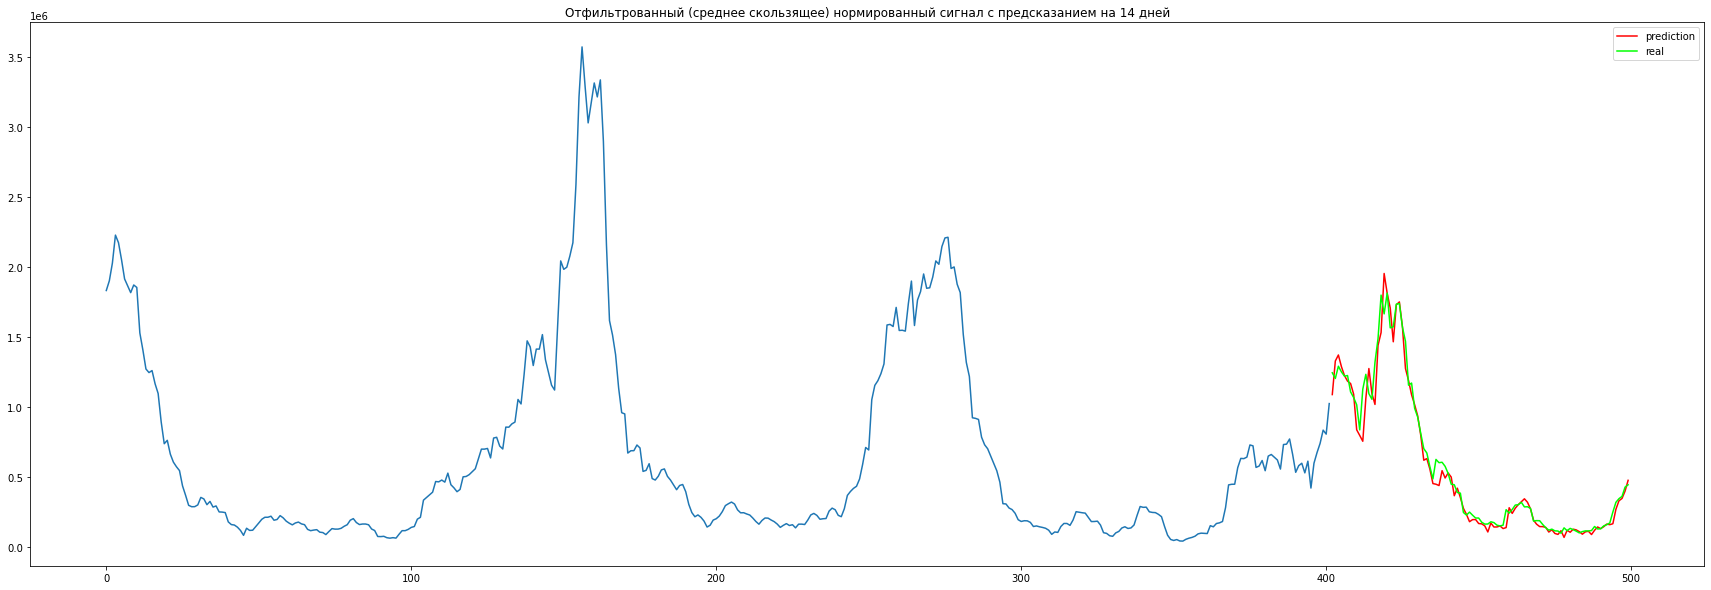

In [60]:
plt.figure(figsize=[30,10])
xscale_test = [len(x_train_ma) + i for i in range(len(x_test_ma))]
plt.plot(x_train_ma.index, x_train_ma[f'cashMA5+{n_lags}'])
plt.plot(xscale_test, output_lst, label='prediction', color='red')
plt.plot(xscale_test, x_test_ma[f'cashMA5+{n_lags}'], label='real', color='lime')
plt.title('Отфильтрованный (среднее скользящее) нормированный сигнал с предсказанием на 14 дней')
plt.legend()
plt.show()

Получили весьма неплохое сходство тестовых данных и предсказания! Проверка показывает, что модель может выдавать неплохой прогноз и на более длительные сроки, чем 14 дней. Стоит, правда, учесть, что модель предсказывает результаты, соответствующие усредненным значениям, поскольку к данным было применено скользящее среднее.

In [61]:
print('MSE: ', mse(x_test_ma[f'cashMA5+{n_lags}'], output_lst))
print('MAE: ', mae(x_test_ma[f'cashMA5+{n_lags}'], output_lst))

MSE:  7798296908.234044
MAE:  52884.66149809419


Text(0.5, 0, 'Lag')

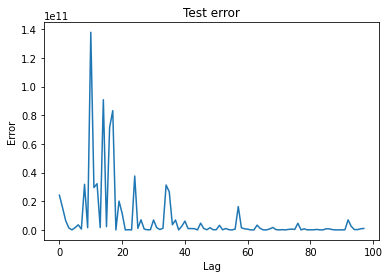

In [62]:
plt.plot(loss_test)
plt.title('Test error')
plt.ylabel('Error')
plt.xlabel('Lag')

In [63]:
ost_ma = [i - j for i, j in zip(list(x_test_ma[f'cashMA5+{n_lags}']),output_lst)]

В идеале, остатки должны в среднем равняться нулю, что будет соответствовать некоррелированому (белому) шуму. Поскольку в данном случае это не так, значит модель все еще можно улучшить, другими словами, из данных "выбрана" не вся полезная информация.

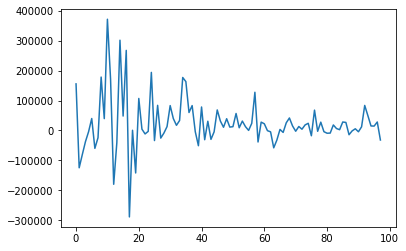

In [64]:
plt.plot(ost_ma)

In [65]:
np.mean(ost_ma)

23956.023958541744

### Catboost

Для сравнения используем Catboost на тех же данных, с добавлением экзогенных признаков. Catboost выбран по причине неплохой предсказательной способности без подгонки параметров.

In [66]:
regr = CatBoostRegressor()

In [67]:
data_ma['mean']=data_ma.mean(axis=1)
data_ma['max']=data_ma.max(axis=1)
data_ma['min']=data_ma.min(axis=1)
data_ma['var']=data_ma.var(axis=1)
data_ma['std']=data_ma.std(axis=1)
data_ma['median']=data_ma.median(axis=1)
data_ma

,cashMA5,cashMA5+1,cashMA5+2,cashMA5+3,cashMA5+4,cashMA5+5,cashMA5+6,cashMA5+7,cashMA5+8,cashMA5+9,...,cashMA5+11,cashMA5+12,cashMA5+13,cashMA5+14,mean,max,min,var,std,median
0,1.239586e+06,1.508350e+06,1.613744e+06,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,...,1.579970e+06,1.745390e+06,1.839553e+06,1.832423e+06,1.646676e+06,1.839553e+06,1.239586e+06,3.283541e+10,7.532584e+09,1.654608e+06
1,1.508350e+06,1.613744e+06,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,...,1.745390e+06,1.839553e+06,1.832423e+06,1.902006e+06,1.690838e+06,1.902006e+06,1.508350e+06,1.799364e+10,4.127636e+09,1.712009e+06
2,1.613744e+06,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,...,1.839553e+06,1.832423e+06,1.902006e+06,2.028152e+06,1.725491e+06,2.028152e+06,1.535985e+06,2.454792e+10,5.631282e+09,1.739285e+06
3,1.560164e+06,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,1.745390e+06,...,1.832423e+06,1.902006e+06,2.028152e+06,2.227992e+06,1.766441e+06,2.227992e+06,1.535985e+06,4.520874e+10,1.037119e+10,1.781315e+06
4,1.609780e+06,1.830180e+06,1.733181e+06,1.796190e+06,1.613109e+06,1.662540e+06,1.535985e+06,1.579970e+06,1.745390e+06,1.839553e+06,...,1.902006e+06,2.028152e+06,2.227992e+06,2.173756e+06,1.807347e+06,2.227992e+06,1.535985e+06,5.017490e+10,1.151050e+10,1.818764e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.249228e+05,1.145381e+05,1.023035e+05,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,...,1.609332e+05,1.734996e+05,2.512855e+05,3.206797e+05,1.515861e+05,3.206797e+05,1.023035e+05,4.695957e+09,1.077290e+09,1.397201e+05
496,1.145381e+05,1.023035e+05,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,1.522583e+05,...,1.734996e+05,2.512855e+05,3.206797e+05,3.465804e+05,1.663633e+05,3.465804e+05,1.023035e+05,7.028000e+09,1.612294e+09,1.500873e+05
497,1.023035e+05,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,1.522583e+05,1.609332e+05,...,2.512855e+05,3.206797e+05,3.465804e+05,3.628644e+05,1.829183e+05,3.628644e+05,1.023035e+05,9.046509e+09,2.075368e+09,1.565958e+05
498,1.115227e+05,1.166749e+05,1.163258e+05,1.189613e+05,1.479163e+05,1.304456e+05,1.315238e+05,1.522583e+05,1.609332e+05,1.734996e+05,...,3.206797e+05,3.465804e+05,3.628644e+05,4.288821e+05,2.046903e+05,4.288821e+05,1.115227e+05,1.296101e+10,2.973410e+09,1.672164e+05


In [68]:
x_train_ma = data_ma[:-test]
x_test_ma = data_ma[-test:].reset_index().drop('index', axis=1)

In [69]:
regr.fit(x_train_ma.drop([f'cashMA5+{nlags}'], axis=1).loc[:,'cashMA5':], x_train_ma.loc[:, f'cashMA5+{nlags}'])

Learning rate set to 0.035453
0:	learn: 677425.5316099	total: 153ms	remaining: 2m 32s
1:	learn: 658775.8109787	total: 155ms	remaining: 1m 17s
2:	learn: 640520.0548762	total: 158ms	remaining: 52.5s
3:	learn: 623231.0111021	total: 160ms	remaining: 39.9s
4:	learn: 605952.5846283	total: 163ms	remaining: 32.3s
5:	learn: 589901.9430530	total: 165ms	remaining: 27.3s
6:	learn: 573907.0090407	total: 167ms	remaining: 23.7s
7:	learn: 560443.8596975	total: 170ms	remaining: 21.1s
8:	learn: 545534.4145277	total: 173ms	remaining: 19s
9:	learn: 532122.1908883	total: 176ms	remaining: 17.4s
10:	learn: 518687.1058344	total: 178ms	remaining: 16s
11:	learn: 505351.4549481	total: 182ms	remaining: 15s
12:	learn: 493577.9290691	total: 185ms	remaining: 14s
13:	learn: 480788.3734356	total: 188ms	remaining: 13.2s
14:	learn: 468660.9505624	total: 191ms	remaining: 12.5s
15:	learn: 456442.8960658	total: 193ms	remaining: 11.9s
16:	learn: 445691.0280153	total: 195ms	remaining: 11.3s
17:	learn: 434728.8929784	total: 1

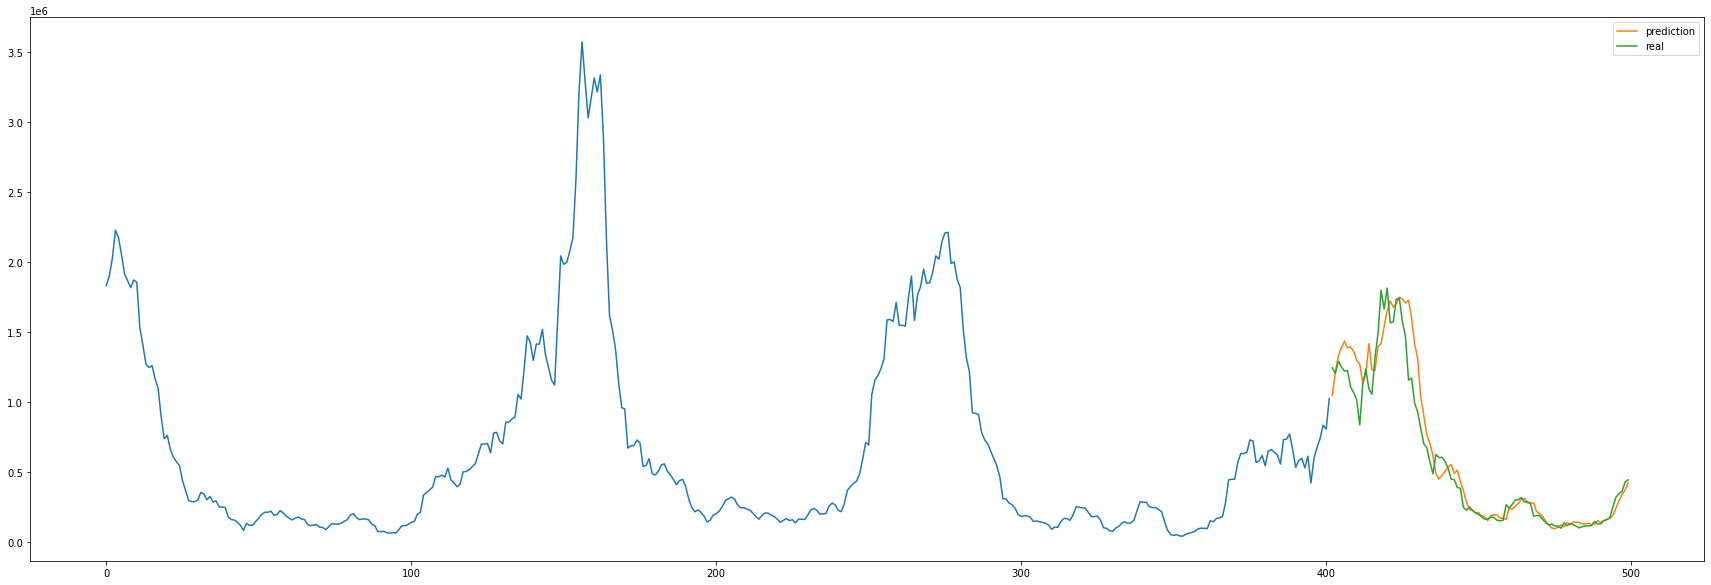

In [70]:
plt.figure(figsize=[30,10])
xsc = [len(x_train_ma) + i for i in range(test)]
plt.plot(x_train_ma.loc[:, f'cashMA5+{nlags}'])
plt.plot(xsc,regr.predict(x_test_ma.drop([f'cashMA5+{nlags}'], axis=1).loc[:,'cashMA5':]), label='prediction')
plt.plot(xsc,x_test_ma.loc[:,f'cashMA5+{nlags}'], label='real')
plt.legend()
plt.show()

Полученные результаты вполне неплохо предсказывают дальнейшие значения ряда                                                     

# Результаты

По итогу удалось получить две модели. Совсем быстрое решение — Catboost на данных ряда со сдвигом на лаг и стандартных экзогенных признаках. Более точное решение получилось с помощью полносвязной нейронной сети. Итоговое предсказание на нейронной сети:

In [71]:
pd.DataFrame(output_lst, columns=['Predictions'])

,Predictions
0,1.089693e+06
1,1.329426e+06
2,1.372297e+06
3,1.288822e+06
4,1.224838e+06
...,...
93,2.708739e+05
94,3.314340e+05
95,3.481640e+05
96,4.005063e+05


Итоговое предсказание для Catboost:

In [72]:
pd.DataFrame(regr.predict(x_test_ma.drop([f'cashMA5+{nlags}'], axis=1).loc[:,'cashMA5':]), columns=['Predictions'])

,Predictions
0,1.047822e+06
1,1.212525e+06
2,1.332918e+06
3,1.387933e+06
4,1.435638e+06
...,...
93,2.429105e+05
94,2.963476e+05
95,3.384329e+05
96,3.726503e+05


Ошибки для нейронной сети:

In [73]:
print('MSE: ', mse(x_test_ma[f'cashMA5+{n_lags}'], output_lst))
print('MAE: ', mae(x_test_ma[f'cashMA5+{n_lags}'], output_lst))

MSE:  7798296908.234044
MAE:  52884.66149809419


Ошибки Catboost:

In [74]:
print('MSE: ', mse(regr.predict(x_test_ma.drop([f'cashMA5+{nlags}'], axis=1).loc[:,'cashMA5':]), 
                   x_test_ma.loc[:,f'cashMA5+{nlags}']))
print('MAE: ', mae(regr.predict(x_test_ma.drop([f'cashMA5+{nlags}'], axis=1).loc[:,'cashMA5':]), 
                   x_test_ma.loc[:,f'cashMA5+{nlags}']))

MSE:  22020770854.7222
MAE:  91590.38041280558


В целом, возможно в данном случае хватило бы и регрессии, можно было воспользоваться (S)ARIMA.

Прогнозирование данной моделью возможно и на более долгий период, чем 14 дней. Результаты не сильно расходятся с реальными данными.

Коэффициент детерминации

In [75]:
y_hat = output_lst

In [76]:
y = x_test_ma[f'cashMA5+{nlags}']

In [77]:
y_mean = x_test_ma[f'cashMA5+{nlags}'].mean()

In [78]:
RSS = 0
TSS = 0
for i in range(len(output_lst)):
    RSS += (y[i] - y_hat[i]) ** 2
    TSS += (y[i] - y_mean) ** 2
1 - RSS/TSS

0.9707443352596633